In [1]:
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, dataloader, random_split
from torch import nn
import torch

from math import ceil, floor

from typing import List, Tuple

import matplotlib.pyplot as plt

In [2]:
num_workers = 1
pin_memory = True
seed = 123
device = torch.device('cpu')
if torch.cuda.is_available():
    print('using device: cuda')
    device = torch.device('cuda')
    #torch.cuda.empty_cache()
    #torch.cuda.memory_summary(device=None, abbreviated=False)
    torch.cuda.manual_seed(seed)
    num_workers = 0
    pin_memory = False

using device: cuda


In [3]:
class dataset_builder(Dataset):
    def __init__(self, train_mode=True) -> None:
        if train_mode:
            data = pd.read_csv("../input/titanic/train.csv")
        else:
            data = pd.read_csv("../input/titanic/test.csv")
            
        data.fillna("missing", inplace=True)
        data["cabin_deck"] = data["Cabin"].apply(lambda x: x[0] if x != "missing" else "missing")
        data["Sex"].replace({"missing": 0, "male": 1, "female": 2}, inplace=True)
        data["Embarked"].replace({"missing": 0, "S": 1, "C": 2, "Q": 3}, inplace=True)
        data["Age"].replace({"missing": 0}, inplace=True)
        data["Fare"].replace({"missing": 0}, inplace=True)
        data["cabin_deck"].replace({"missing": 0,
                                     "A": 1,
                                     "B": 2,
                                     "C": 3,
                                     "D": 4,
                                     "E": 5,
                                     "F": 6,
                                     "G": 7,
                                     "T": 8}, inplace=True)
        data.drop(["Ticket", "Name", "Cabin"], axis=1, inplace=True)
        
        self.ids = data.pop("PassengerId").to_numpy()
        # self.dataframe = train
        if train_mode:
            self.labels = data.pop("Survived").to_numpy()
        else:
            self.labels = np.zeros(self.ids.shape)
        self.features = data.astype(np.float32).to_numpy()
        
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """ Returns features and label from given index.
        Args:
            index (int): Index of sample in dataset.
        Returns:
            torch.Tensor: Tensor of features.
            torch.Tensor: Tensor of labels.
        """
        label = torch.from_numpy(np.asarray(self.labels[index].astype(np.float32))).type(torch.LongTensor).to(device=device)
        feats =  torch.from_numpy(np.asarray(self.features[index].astype(np.float32))).to(device=device)
        return feats, label

    def __len__(self) -> int:
        """ Return length of dataset.
        Returns:
            int: length of dataset.
        """
        return len(self.ids)

    
def get_dataloader(shuffle=True,
                   batch_size=64,
                   valid_percent=0.3,
                   train_mode=True):
    dataset = dataset_builder(train_mode=train_mode)
    
    index = list(range(dataset.__len__()))
    
    if shuffle:
        np.random.seed(seed)
        np.random.shuffle(index)
    
    if train_mode:
        train_index, valid_index = random_split(index, [ceil((1-valid_percent)*len(index)),
                                                        floor(valid_percent*len(index))], generator=torch.Generator().manual_seed(seed))

        train_sampler = SubsetRandomSampler(train_index)
        valid_sampler = SubsetRandomSampler(valid_index)
        return (DataLoader(
                    dataset,
                    batch_size=batch_size,
                    sampler=train_sampler,
                    num_workers=num_workers,
                    pin_memory=pin_memory,
                    ),
    
                DataLoader(
                    dataset,
                    batch_size=batch_size,
                    sampler=valid_sampler,
                    num_workers=num_workers,
                    pin_memory=pin_memory,
                    ))

    else:
        return DataLoader(
                    dataset,
                    batch_size=batch_size,
                    num_workers=num_workers,
                    pin_memory=pin_memory,
                    )


class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim),
            nn.Sigmoid()
        ).to(device=device)
        
    def forward(self, x):
        x = self.layers(x)
        return x

In [4]:
train_loader, valid_loader = get_dataloader()
test_loader = get_dataloader(train_mode=False)

In [5]:
model = MLP(8, 50, 2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

mean_train_losses = []
mean_valid_losses = []
valid_acc_list = []
epochs = 1000

for epoch in range(epochs):
    model.train()
    
    train_losses = []
    valid_losses = []
    correct = 0
    total = 0
    for i, (feats, labels) in enumerate(train_loader):
        
        optimizer.zero_grad()
        
        outputs = model(feats)
        pred = torch.max(outputs.data, 1)
        correct += (pred == labels)#}.sum()#.item()
        total += labels.size(0)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        
        if (i * 128) % (128 * 100) == 0:
            print(f'{i * 128} / 50000')
    train_accuracy = 100*correct/total
    
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(valid_loader):
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            
            valid_losses.append(loss.item())
            
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
    mean_train_losses.append(np.mean(train_losses))
    mean_valid_losses.append(np.mean(valid_losses))
    
    accuracy = 100*correct/total
    valid_acc_list.append(accuracy)
    print('epoch : {}, train loss : {:.4f}, train acc : {:.2f}%, valid loss : {:.4f}, valid acc : {:.2f}%'\
         .format(epoch+1, train_accuracy, np.mean(train_losses), np.mean(valid_losses), accuracy))

0 / 50000
epoch : 1, train loss : 0.0000, train acc : 0.69%, valid loss : 0.6740, valid acc : 56.18%
0 / 50000
epoch : 2, train loss : 0.0000, train acc : 0.67%, valid loss : 0.6543, valid acc : 64.42%
0 / 50000
epoch : 3, train loss : 0.0000, train acc : 0.66%, valid loss : 0.6470, valid acc : 64.42%
0 / 50000
epoch : 4, train loss : 0.0000, train acc : 0.65%, valid loss : 0.6258, valid acc : 64.42%
0 / 50000
epoch : 5, train loss : 0.0000, train acc : 0.65%, valid loss : 0.6276, valid acc : 64.42%
0 / 50000
epoch : 6, train loss : 0.0000, train acc : 0.65%, valid loss : 0.6125, valid acc : 64.42%
0 / 50000
epoch : 7, train loss : 0.0000, train acc : 0.64%, valid loss : 0.5821, valid acc : 64.42%
0 / 50000
epoch : 8, train loss : 0.0000, train acc : 0.64%, valid loss : 0.6063, valid acc : 64.42%
0 / 50000
epoch : 9, train loss : 0.0000, train acc : 0.64%, valid loss : 0.6156, valid acc : 64.42%
0 / 50000
epoch : 10, train loss : 0.0000, train acc : 0.64%, valid loss : 0.6124, valid ac

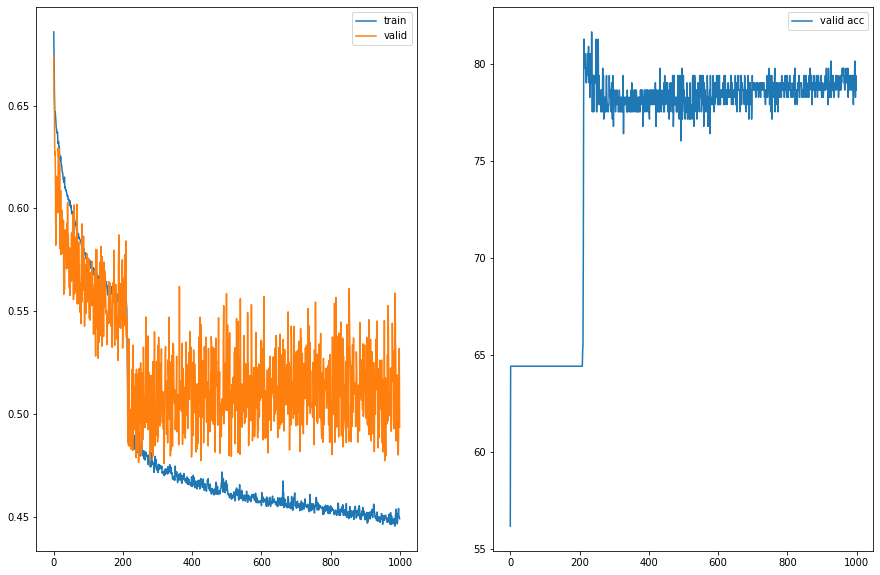

In [6]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
ax1.plot(mean_train_losses, label='train')
ax1.plot(mean_valid_losses, label='valid')
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='best')

ax2.plot(valid_acc_list, label='valid acc')
ax2.legend()
plt.show()

In [7]:
model.eval()
test_preds = torch.LongTensor().to(device=device)

for i, (feats, _) in enumerate(test_loader):
    outputs = model(feats)
    
    pred = outputs.max(1, keepdim=True)[1]
    test_preds = torch.cat((test_preds, pred), dim=0)
    
out_df = pd.DataFrame()
out_df['PassengerId'] = dataset_builder(train_mode=False).ids
out_df['Survived'] = test_preds.cpu().numpy()

out_df.to_csv('submission.csv', index=None)

In [8]:
out_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
